# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

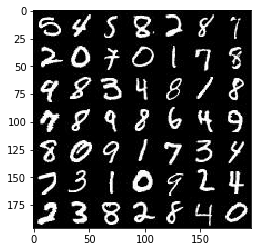

In [2]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

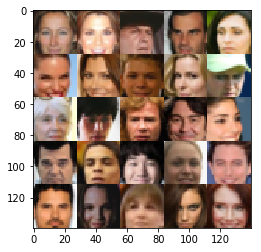

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [39]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [40]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_inputs = tf.placeholder(dtype = tf.float32, shape = [None, image_height, image_width, image_channels], name = 'real_inputs')
    generation_seeds = tf.placeholder(dtype = tf.float32, shape = [None, z_dim], name = 'generation_seeds')
    learning_rate = tf.placeholder(dtype = tf.float32, name = 'learning_rate')

    return real_inputs, generation_seeds, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [41]:
def discriminator(images, reuse = False, alpha = 0.01, drop_rate = 0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    is_train = not reuse
    
    with tf.variable_scope('discriminator', reuse = reuse):
        
        h, w, c = 28, 28, 4  # Input
                
        disc_flow = tf.layers.conv2d(
            inputs = images, 
            filters = 16, 
            kernel_size = 5, 
            strides = 2,
            padding = 'same')
        disc_flow = tf.maximum(alpha * disc_flow, disc_flow)
        if drop_rate > 0: disc_flow = tf.layers.dropout(inputs = disc_flow, training = is_train, rate = drop_rate, seed = 17)
        
        h, w, c = 14, 14, 16
        
        disc_flow = tf.layers.conv2d(
            inputs = disc_flow, 
            filters = 32, 
            kernel_size = 5, 
            strides = 2,
            padding = 'same') 
        disc_flow = tf.layers.batch_normalization(
            inputs = disc_flow, 
            training = is_train)
        disc_flow = tf.maximum(alpha * disc_flow, disc_flow)
        if drop_rate > 0: disc_flow = tf.layers.dropout(inputs = disc_flow, training = is_train, rate = drop_rate, seed = 17)
        
        h, w, c = 7, 7, 32
        
        disc_flow = tf.layers.conv2d(
            inputs = disc_flow, 
            filters = 64, 
            kernel_size = 3, 
            strides = 1,
            padding = 'same')
        disc_flow = tf.layers.batch_normalization(
            inputs = disc_flow, 
            training = is_train)
        disc_flow = tf.maximum(alpha * disc_flow, disc_flow)
        if drop_rate > 0: disc_flow = tf.layers.dropout(inputs = disc_flow, training = is_train, rate = drop_rate, seed = 17)
        
        h, w, c = 7, 7, 64
        
        disc_flow = tf.reshape(tensor = disc_flow, shape = [-1, h * w * c])
        disc_flow = tf.layers.dense(
            inputs = disc_flow, 
            units = 1)
        output = tf.tanh(disc_flow)
        
    return output, disc_flow

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [42]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.01, drop_rate = 0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse = not is_train):
    
        h, w, c = 7, 7, 128  # Start

        gen_flow = tf.layers.dense(
            inputs = z,
            units = h * w * c)
        gen_flow = tf.reshape(
            tensor = gen_flow, 
            shape = [-1, h, w, c])
        gen_flow = tf.layers.batch_normalization(
            inputs = gen_flow, 
            training = is_train)
        gen_flow = tf.maximum(alpha * gen_flow, gen_flow)

        h, w, c = 7, 7, 128

        gen_flow = tf.layers.conv2d_transpose(
            inputs = gen_flow, 
            filters = 64, 
            kernel_size = 3, 
            strides = 1, 
            padding = 'same')
        gen_flow = tf.layers.batch_normalization(
            inputs = gen_flow, 
            training = is_train)
        gen_flow = tf.maximum(alpha * gen_flow, gen_flow)
        if drop_rate > 0: gen_flow = tf.layers.dropout(inputs = gen_flow, training = is_train, rate = drop_rate, seed = 17)

        h, w, c = 7, 7, 64

        gen_flow = tf.layers.conv2d_transpose(
            inputs = gen_flow, 
            filters = 32, 
            kernel_size = 3, 
            strides = 2, 
            padding = 'same')
        gen_flow = tf.layers.batch_normalization(
            inputs = gen_flow, 
            training = is_train)
        gen_flow = tf.maximum(alpha * gen_flow, gen_flow)
        if drop_rate > 0: gen_flow = tf.layers.dropout(inputs = gen_flow, training = is_train, rate = drop_rate, seed = 17)
        
        h, w, c = 14, 14, 32
        
        gen_flow = tf.layers.conv2d_transpose(
            inputs = gen_flow, 
            filters = 16, 
            kernel_size = 5, 
            strides = 2, 
            padding = 'same')
        gen_flow = tf.layers.batch_normalization(
            inputs = gen_flow, 
            training = is_train)
        gen_flow = tf.maximum(alpha * gen_flow, gen_flow)
        if drop_rate > 0: gen_flow = tf.layers.dropout(inputs = gen_flow, training = is_train, rate = drop_rate, seed = 17)
        
        h, w, c = 28, 28, 16
        
        gen_flow = tf.layers.conv2d_transpose(
            inputs = gen_flow, 
            filters = out_channel_dim, 
            kernel_size = 7, 
            strides = 1, 
            padding = 'same')
        
        h, w, c = 28, 28, out_channel_dim
        
        out = tf.tanh(gen_flow)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [48]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.01, drop_rate = 0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    input_real = tf.multiply(input_real, 2)  # Scale input images by 2 from [-.5,.5] -> [-1,1]

    g_out = generator(z = input_z, out_channel_dim = out_channel_dim, is_train = True, alpha = alpha, drop_rate = drop_rate)
    d_real_out, d_real_layer = discriminator(images = input_real, reuse = False, alpha = alpha, drop_rate = drop_rate)
    d_fake_out, d_fake_layer = discriminator(images = g_out, reuse = True, alpha = alpha, drop_rate = drop_rate)
    
    g_loss = tf.reduce_mean(
        input_tensor = tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_fake_layer, 
            labels = tf.multiply(tf.ones_like(d_fake_out), 1)))
    
    d_real_loss = tf.reduce_mean(
        input_tensor = tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_real_layer, 
            labels = tf.multiply(tf.ones_like(d_real_out), 1)))
    d_fake_loss = tf.reduce_mean(
        input_tensor = tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_fake_layer, 
            labels = tf.multiply(tf.ones_like(d_fake_out), 0)))

    d_loss = d_real_loss + d_fake_loss

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [49]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [50]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [51]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, drop_rate = 0.1, alpha = 0.2):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    tf.reset_default_graph()
    
    real_inputs, generation_seeds, lr = model_inputs(
        image_width = data_shape[1], 
        image_height =  data_shape[2], 
        image_channels = data_shape[3], 
        z_dim = z_dim)
    
    d_loss, g_loss = model_loss(
        input_real = real_inputs, 
        input_z = generation_seeds, 
        out_channel_dim = data_shape[3], 
        alpha = alpha,
        drop_rate = drop_rate)

    g_opt, d_opt = model_opt(
        d_loss = d_loss, 
        g_loss = g_loss, 
        learning_rate = lr, 
        beta1 = beta1)    

    steps = 0
    # saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for x in get_batches(batch_size):
                
                steps += 1

                z = np.random.uniform(low = -1, high = 1, size = [batch_size, z_dim])

                feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate}
                
                # _ = sess.run(d_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                # _ = sess.run(g_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                _ = sess.run(d_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                # _ = sess.run(d_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                # _ = sess.run(g_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                # _ = sess.run(g_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                # _ = sess.run(g_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})

                if steps % 16 == 0:
                    
                    d_train_loss = d_loss.eval({generation_seeds: z, real_inputs: x})
                    g_train_loss = g_loss.eval({generation_seeds: z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "D Loss: {:.4f}...".format(d_train_loss),
                          "G Loss: {:.4f}".format(g_train_loss))
                    
                if steps % 128 == 0:
                    
                    show_generator_output(
                        sess = sess, 
                        n_images = 25, 
                        input_z = generation_seeds, 
                        out_channel_dim = data_shape[3], 
                        image_mode = data_image_mode)

        # saver.save(sess, './checkpoints/generator.ckpt')                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... D Loss: 0.6222... G Loss: 0.8019
Epoch 1/2... D Loss: 0.1969... G Loss: 1.8132
Epoch 1/2... D Loss: 0.0470... G Loss: 3.3078
Epoch 1/2... D Loss: 0.0212... G Loss: 4.0859
Epoch 1/2... D Loss: 0.0156... G Loss: 4.5535
Epoch 1/2... D Loss: 0.0096... G Loss: 5.0097
Epoch 1/2... D Loss: 0.0060... G Loss: 5.5602
Epoch 1/2... D Loss: 0.0053... G Loss: 5.9444


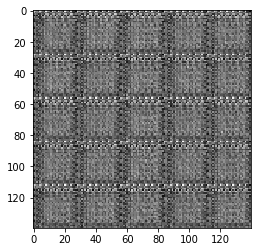

Epoch 1/2... D Loss: 0.0035... G Loss: 6.2808
Epoch 1/2... D Loss: 0.0025... G Loss: 6.4584
Epoch 1/2... D Loss: 0.0026... G Loss: 6.5375


IndexError: list index out of range

In [53]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
alpha = 0.2
beta1 = 0.5
drop_rate = 0

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha = alpha, drop_rate = drop_rate)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... D Loss: 1.0080... G Loss: 0.8137
Epoch 1/1... D Loss: 0.7678... G Loss: 1.3810
Epoch 1/1... D Loss: 0.6833... G Loss: 1.8652
Epoch 1/1... D Loss: 0.6735... G Loss: 2.0411
Epoch 1/1... D Loss: 0.6797... G Loss: 2.0967
Epoch 1/1... D Loss: 0.6920... G Loss: 2.0102
Epoch 1/1... D Loss: 0.6849... G Loss: 2.2057
Epoch 1/1... D Loss: 0.6737... G Loss: 2.0398


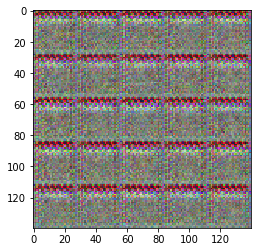

Epoch 1/1... D Loss: 0.6697... G Loss: 2.2016
Epoch 1/1... D Loss: 0.6728... G Loss: 2.1334
Epoch 1/1... D Loss: 0.6716... G Loss: 2.1829
Epoch 1/1... D Loss: 0.6779... G Loss: 2.1966
Epoch 1/1... D Loss: 0.6972... G Loss: 2.0534
Epoch 1/1... D Loss: 0.6963... G Loss: 2.1684
Epoch 1/1... D Loss: 0.6715... G Loss: 2.1318
Epoch 1/1... D Loss: 0.6718... G Loss: 2.0627


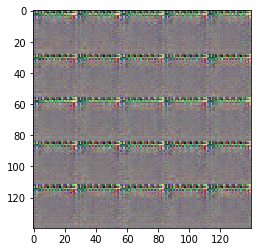

Epoch 1/1... D Loss: 0.6672... G Loss: 2.0969
Epoch 1/1... D Loss: 0.6709... G Loss: 2.0651
Epoch 1/1... D Loss: 0.6809... G Loss: 2.0209
Epoch 1/1... D Loss: 0.6657... G Loss: 2.1801
Epoch 1/1... D Loss: 0.6600... G Loss: 2.0636
Epoch 1/1... D Loss: 0.6674... G Loss: 2.1300
Epoch 1/1... D Loss: 0.6643... G Loss: 2.0674
Epoch 1/1... D Loss: 0.6624... G Loss: 2.1671


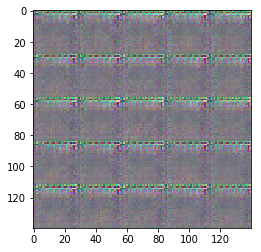

Epoch 1/1... D Loss: 0.6626... G Loss: 2.0939
Epoch 1/1... D Loss: 0.6618... G Loss: 2.1745
Epoch 1/1... D Loss: 0.6636... G Loss: 2.0922
Epoch 1/1... D Loss: 0.6578... G Loss: 2.0790
Epoch 1/1... D Loss: 0.6641... G Loss: 2.1111
Epoch 1/1... D Loss: 0.6664... G Loss: 2.0643
Epoch 1/1... D Loss: 0.6634... G Loss: 2.0825
Epoch 1/1... D Loss: 0.6633... G Loss: 2.0606


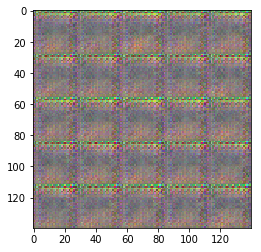

Epoch 1/1... D Loss: 0.6593... G Loss: 2.1466
Epoch 1/1... D Loss: 0.6608... G Loss: 2.0841
Epoch 1/1... D Loss: 0.6612... G Loss: 2.0597
Epoch 1/1... D Loss: 0.6602... G Loss: 2.0900
Epoch 1/1... D Loss: 0.6650... G Loss: 2.0432
Epoch 1/1... D Loss: 0.6560... G Loss: 2.1668
Epoch 1/1... D Loss: 0.6629... G Loss: 2.1411
Epoch 1/1... D Loss: 0.6638... G Loss: 2.0955


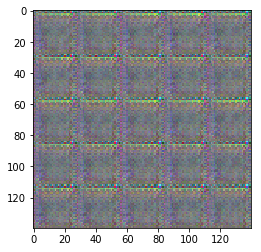

Epoch 1/1... D Loss: 0.6629... G Loss: 2.0472
Epoch 1/1... D Loss: 0.6586... G Loss: 2.0738
Epoch 1/1... D Loss: 0.6602... G Loss: 2.0960
Epoch 1/1... D Loss: 0.6582... G Loss: 2.0644
Epoch 1/1... D Loss: 0.6564... G Loss: 2.0959
Epoch 1/1... D Loss: 0.6627... G Loss: 2.0769
Epoch 1/1... D Loss: 0.6600... G Loss: 2.0876
Epoch 1/1... D Loss: 0.6589... G Loss: 2.1169


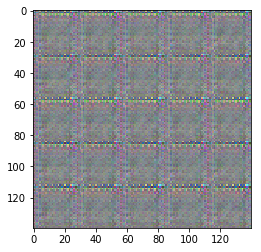

Epoch 1/1... D Loss: 0.6587... G Loss: 2.0812
Epoch 1/1... D Loss: 0.6619... G Loss: 2.0662
Epoch 1/1... D Loss: 0.6595... G Loss: 2.1174
Epoch 1/1... D Loss: 0.6603... G Loss: 2.0764
Epoch 1/1... D Loss: 0.6614... G Loss: 2.0681
Epoch 1/1... D Loss: 0.6617... G Loss: 2.0930
Epoch 1/1... D Loss: 0.6560... G Loss: 2.0901
Epoch 1/1... D Loss: 0.6578... G Loss: 2.0675


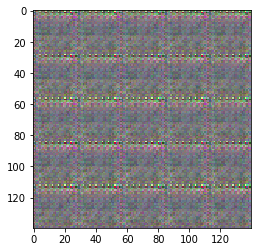

Epoch 1/1... D Loss: 0.6566... G Loss: 2.1057
Epoch 1/1... D Loss: 0.6624... G Loss: 2.0750
Epoch 1/1... D Loss: 0.6633... G Loss: 2.0742
Epoch 1/1... D Loss: 0.6612... G Loss: 2.0956
Epoch 1/1... D Loss: 0.6605... G Loss: 2.0849
Epoch 1/1... D Loss: 0.6624... G Loss: 2.0452
Epoch 1/1... D Loss: 0.6618... G Loss: 2.0697
Epoch 1/1... D Loss: 0.6591... G Loss: 2.0650


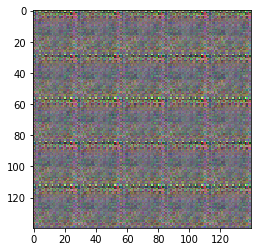

Epoch 1/1... D Loss: 0.6568... G Loss: 2.1028
Epoch 1/1... D Loss: 0.6575... G Loss: 2.0350
Epoch 1/1... D Loss: 0.6579... G Loss: 2.0610
Epoch 1/1... D Loss: 0.6572... G Loss: 2.1126
Epoch 1/1... D Loss: 0.6601... G Loss: 2.0823
Epoch 1/1... D Loss: 0.6674... G Loss: 2.0977
Epoch 1/1... D Loss: 0.6611... G Loss: 2.0737
Epoch 1/1... D Loss: 0.6595... G Loss: 2.0608


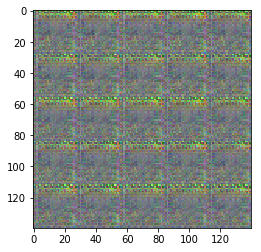

Epoch 1/1... D Loss: 0.6600... G Loss: 2.1099
Epoch 1/1... D Loss: 0.6553... G Loss: 2.0640
Epoch 1/1... D Loss: 0.6571... G Loss: 2.0829
Epoch 1/1... D Loss: 0.6569... G Loss: 2.0773
Epoch 1/1... D Loss: 0.6580... G Loss: 2.0885
Epoch 1/1... D Loss: 0.6572... G Loss: 2.0978
Epoch 1/1... D Loss: 0.6589... G Loss: 2.0535
Epoch 1/1... D Loss: 0.6580... G Loss: 2.1214


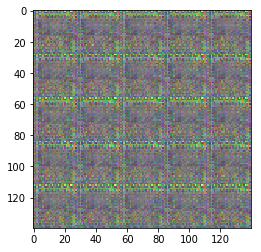

Epoch 1/1... D Loss: 0.6569... G Loss: 2.0792
Epoch 1/1... D Loss: 0.6613... G Loss: 2.0601
Epoch 1/1... D Loss: 0.6580... G Loss: 2.0782
Epoch 1/1... D Loss: 0.6606... G Loss: 2.0878
Epoch 1/1... D Loss: 0.6573... G Loss: 2.1001
Epoch 1/1... D Loss: 0.6602... G Loss: 2.0545
Epoch 1/1... D Loss: 0.6601... G Loss: 2.0688
Epoch 1/1... D Loss: 0.6594... G Loss: 2.0409


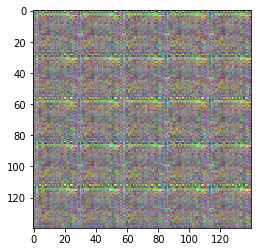

Epoch 1/1... D Loss: 0.6561... G Loss: 2.0972
Epoch 1/1... D Loss: 0.6567... G Loss: 2.0692
Epoch 1/1... D Loss: 0.6550... G Loss: 2.0770
Epoch 1/1... D Loss: 0.6596... G Loss: 2.0732
Epoch 1/1... D Loss: 0.6580... G Loss: 2.0970
Epoch 1/1... D Loss: 0.6585... G Loss: 2.0704
Epoch 1/1... D Loss: 0.6549... G Loss: 2.0180
Epoch 1/1... D Loss: 0.6583... G Loss: 2.0187


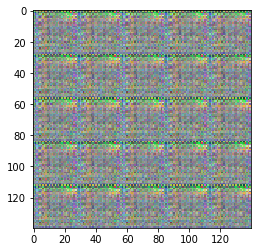

Epoch 1/1... D Loss: 0.6586... G Loss: 2.0602
Epoch 1/1... D Loss: 0.6579... G Loss: 2.0597
Epoch 1/1... D Loss: 0.6567... G Loss: 2.0444
Epoch 1/1... D Loss: 0.6560... G Loss: 2.0473
Epoch 1/1... D Loss: 0.6576... G Loss: 2.0910
Epoch 1/1... D Loss: 0.6589... G Loss: 2.0949
Epoch 1/1... D Loss: 0.6580... G Loss: 2.0661
Epoch 1/1... D Loss: 0.6553... G Loss: 2.0680


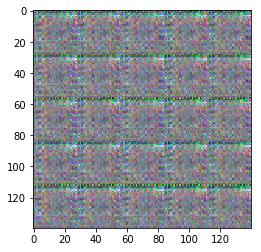

Epoch 1/1... D Loss: 0.6594... G Loss: 2.0688
Epoch 1/1... D Loss: 0.6567... G Loss: 2.0780
Epoch 1/1... D Loss: 0.6548... G Loss: 2.0514
Epoch 1/1... D Loss: 0.6614... G Loss: 2.0808
Epoch 1/1... D Loss: 0.6550... G Loss: 2.0700
Epoch 1/1... D Loss: 0.6566... G Loss: 2.0517
Epoch 1/1... D Loss: 0.6562... G Loss: 2.0937
Epoch 1/1... D Loss: 0.6580... G Loss: 2.0619


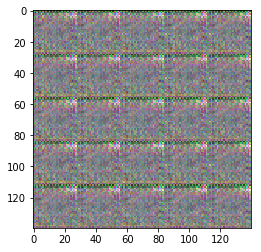

Epoch 1/1... D Loss: 0.6591... G Loss: 2.0785
Epoch 1/1... D Loss: 0.6568... G Loss: 2.0885
Epoch 1/1... D Loss: 0.6565... G Loss: 2.0481
Epoch 1/1... D Loss: 0.6558... G Loss: 2.0777
Epoch 1/1... D Loss: 0.6578... G Loss: 2.0421
Epoch 1/1... D Loss: 0.6576... G Loss: 2.0496
Epoch 1/1... D Loss: 0.6547... G Loss: 2.0950
Epoch 1/1... D Loss: 0.6599... G Loss: 2.0614


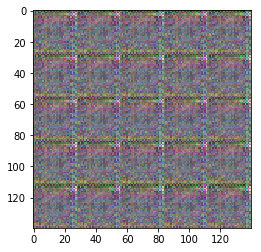

Epoch 1/1... D Loss: 0.6564... G Loss: 2.0807
Epoch 1/1... D Loss: 0.6561... G Loss: 2.0633
Epoch 1/1... D Loss: 0.6538... G Loss: 2.0793
Epoch 1/1... D Loss: 0.6559... G Loss: 2.0490
Epoch 1/1... D Loss: 0.6575... G Loss: 2.0639
Epoch 1/1... D Loss: 0.6547... G Loss: 2.0713
Epoch 1/1... D Loss: 0.6539... G Loss: 2.0730
Epoch 1/1... D Loss: 0.6601... G Loss: 2.0722


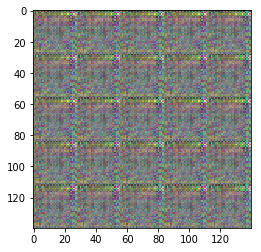

Epoch 1/1... D Loss: 0.6537... G Loss: 2.0654
Epoch 1/1... D Loss: 0.6568... G Loss: 2.0653
Epoch 1/1... D Loss: 0.6553... G Loss: 2.0780
Epoch 1/1... D Loss: 0.6543... G Loss: 2.0978
Epoch 1/1... D Loss: 0.6563... G Loss: 2.0679
Epoch 1/1... D Loss: 0.6555... G Loss: 2.0785
Epoch 1/1... D Loss: 0.6539... G Loss: 2.0878
Epoch 1/1... D Loss: 0.6553... G Loss: 2.0964


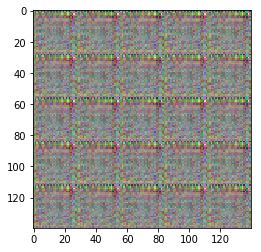

Epoch 1/1... D Loss: 0.6538... G Loss: 2.0887
Epoch 1/1... D Loss: 0.6557... G Loss: 2.1075
Epoch 1/1... D Loss: 0.6540... G Loss: 2.0866
Epoch 1/1... D Loss: 0.6573... G Loss: 2.0613
Epoch 1/1... D Loss: 0.6569... G Loss: 2.1057
Epoch 1/1... D Loss: 0.6569... G Loss: 2.0786
Epoch 1/1... D Loss: 0.6582... G Loss: 2.1402
Epoch 1/1... D Loss: 0.6552... G Loss: 2.0773


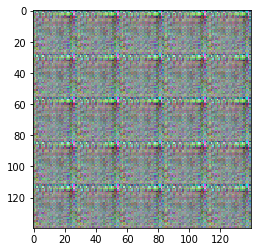

Epoch 1/1... D Loss: 0.6589... G Loss: 2.1016
Epoch 1/1... D Loss: 0.6568... G Loss: 2.1470
Epoch 1/1... D Loss: 0.6575... G Loss: 2.1075
Epoch 1/1... D Loss: 0.6568... G Loss: 2.0701
Epoch 1/1... D Loss: 0.6562... G Loss: 2.0745
Epoch 1/1... D Loss: 0.6549... G Loss: 2.0894
Epoch 1/1... D Loss: 0.6576... G Loss: 2.0718
Epoch 1/1... D Loss: 0.6537... G Loss: 2.0940


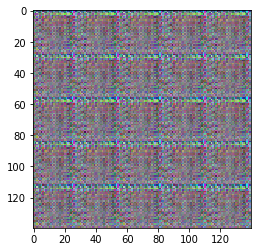

Epoch 1/1... D Loss: 0.6545... G Loss: 2.0720
Epoch 1/1... D Loss: 0.6548... G Loss: 2.0789
Epoch 1/1... D Loss: 0.6545... G Loss: 2.0713
Epoch 1/1... D Loss: 0.6534... G Loss: 2.0868
Epoch 1/1... D Loss: 0.6541... G Loss: 2.0706
Epoch 1/1... D Loss: 0.6556... G Loss: 2.0841
Epoch 1/1... D Loss: 0.6541... G Loss: 2.0241
Epoch 1/1... D Loss: 0.6538... G Loss: 2.0189


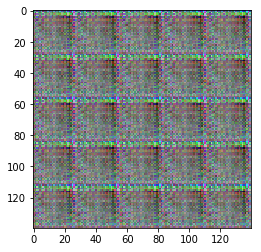

Epoch 1/1... D Loss: 0.6591... G Loss: 2.0858
Epoch 1/1... D Loss: 0.6539... G Loss: 2.1212
Epoch 1/1... D Loss: 0.6537... G Loss: 2.0655
Epoch 1/1... D Loss: 0.6541... G Loss: 2.0623
Epoch 1/1... D Loss: 0.6551... G Loss: 2.0887
Epoch 1/1... D Loss: 0.6534... G Loss: 2.0627
Epoch 1/1... D Loss: 0.6544... G Loss: 2.0679
Epoch 1/1... D Loss: 0.6531... G Loss: 2.0774


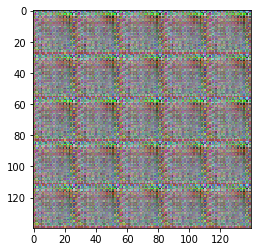

Epoch 1/1... D Loss: 0.6554... G Loss: 2.0702
Epoch 1/1... D Loss: 0.6571... G Loss: 2.0548
Epoch 1/1... D Loss: 0.6566... G Loss: 2.0622
Epoch 1/1... D Loss: 0.6554... G Loss: 2.0018
Epoch 1/1... D Loss: 0.6541... G Loss: 2.0077
Epoch 1/1... D Loss: 0.6560... G Loss: 1.9764
Epoch 1/1... D Loss: 0.6556... G Loss: 2.0477
Epoch 1/1... D Loss: 0.6558... G Loss: 2.0151


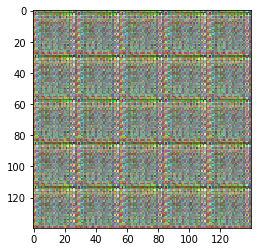

Epoch 1/1... D Loss: 0.6572... G Loss: 2.0119
Epoch 1/1... D Loss: 0.6550... G Loss: 1.9978
Epoch 1/1... D Loss: 0.6570... G Loss: 2.0605
Epoch 1/1... D Loss: 0.6557... G Loss: 2.0564


IndexError: list index out of range

In [19]:
batch_size = 32
z_dim = 128
learning_rate = 0.0001
alpha = 0.2
beta1 = .5
drop_rate = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha = alpha, drop_rate = drop_rate)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.